# Archival Novelty

This notebook explores whether requests to archive web resources were the first such request. Or rather, whether the request provided the Internet Archive with first knowledge of the web resource. Let's call this *archival novelty* which will be a percentage of SavePageNow requests brought new knowledge of a URL to the Internet Archive. We are specifically going to look at *archival novelty* in terms of SavePageNow requests from automated agent or human agents.

The Internet Archive's [CDX API](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server) can tell us exactly when a given URL has been archived over time. But there are 7 million requests for HTML pages in our dataset. So what we will do is generate two random samples for the bots and the humans, and check those against the CDX API.

First we will read in the URLS csv data that we generated in the URLs notebook back into a Spark DataFrame. Remember this only SavePageNow requests that generated an HTML responses, so it doesn't include things like images, JavaScript or CSS that SavePageNow could request when proxying an actual browser. Also we have added a 

In [1]:
import sys
sys.path.append('../utils')

from warc_spark import init, extractor

sc, sqlc = init()
df = sqlc.read.csv('results/urls', header=True)

## Create Samples

Now lets look specifically at 2018, and generate random samples.

In [145]:
y2018 = df.filter(df.date.like('2018%'))
y2018.persist()
count = y2018.count()
print('count {}'.format(count))

bots = y2018.filter(df.bot == True)
bots_sample = bots.sample(0.0001)
print("bots n={} p={}".format(bots_sample.count(), bots.count()))

humans = y2018.filter(df.bot == False)
humans_sample = humans.sample(0.0001)
print("humans n={} p={}".format(humans_sample.count(), humans.count()))

count 1420587
bots n=104 p=1071863
humans n=30 p=348724


In [146]:
y2018.head(5)

[Row(record_id='<urn:uuid:4b4156dd-1eb0-4c17-b2bc-f84a3faa2096>', warc_file='warcs/liveweb-20181025034513/live-20181025033513-wwwb-app15.us.archive.org.warc.gz', date='2018-10-25T03:41:08Z', url='https://www.youtube.com/channel/UCiPsX9jmY6Loe6F8EE6DPMQ/videos?flow=list&sort=p&view=0', user_agent='Wget/1.19.5 (linux-gnu)', user_agent_family='Wget', bot='true'),
 Row(record_id='<urn:uuid:ae91ba84-eb26-4133-863e-7e5ca9cff2b9>', warc_file='warcs/liveweb-20181025160128/live-20181025155856-wwwb-app1.us.archive.org.warc.gz', date='2018-10-25T16:02:08Z', url='https://www.youtube.com/channel/UC3d7Ix6GrtxESULE5Auj_Zg/videos?flow=list&sort=dd&view=0', user_agent='Wget/1.19.5 (linux-gnu)', user_agent_family='Wget', bot='true'),
 Row(record_id='<urn:uuid:3dd9b094-2683-4bee-82f8-6672341e296c>', warc_file='warcs/liveweb-20181025043139/live-20181025040713-wwwb-app1.us.archive.org.warc.gz', date='2018-10-25T04:25:59Z', url='https://crypterium.io/content/cap.json?hz=18984717', user_agent='Mozilla/5.0 (M

## CDX API

Now let's create a function that will return all the times a URL was archived. If supplied the `to` parameter will limit the results to snapshots that were taken prior to (and including) that time. This will limit the results we need to collect since we don't really need to know how many times a URL was collected *after* the time in question.

In [22]:
import requests

def archive_times(url, to=None):
    params = {"output": "json", "url": url, "limit": 10000, 'showResumeKey': True}
    if to:
        params['to'] = to
    
    while True:
        resp = requests.get('http://web.archive.org/cdx/search/cdx', params=params)
        
        if resp.status_code == 403:
            # catch "Blocked Site Error" when robots.txt prevents lookup?
            # e.g. http://www.jeuxvideo.com/forums/42-51-53683620-1-0-1-0-pour-etre-assure-au-niveau-de-la-sante-aux-usa.htm 
            yield None
            break
            
        results = resp.json()
        # ignore header
        for result in results[1:]:
            if len(result) > 1:
                yield int(result[1])
        
        if len(results) != 0 and len(results[-1]) == 1:
            params['resumeKey'] = results[-1][0]
        else:
            break


print('https://mith.umd.edu', list(archive_times('https://mith.umd.edu/', to=20020929183602)))

https://mith.umd.edu [20000815201749, 20001204145800, 20010201091600, 20010203124200, 20010224212144, 20010301092808, 20010302112313, 20010309133144, 20010404212235, 20010418164605, 20010515215143, 20010721201430, 20010924024921, 20011202065537, 20020601134123, 20020604040017, 20020802093507, 20020927173901, 20020929183602]


## Annotate Samples

Now we can add a new column to the sample data to indicate if the URL was new to Internet Archive at at the time. This function `new_url` takes a url and a date and determines whether the snapshot taken at that time was the first one ever seen at that time.

In [8]:
import re

def new_url(url, date):
    # convert 2018-10-25T21:47:18Z to 20181025214718
    request_date = int(re.sub(r'[:TZ-]', '', date))
    
    # cdx results should be sorted, but we'll make sure
    earliest = sorted(archive_times(url, to=request_date))[0]
    
    return request_date == earliest

Let's test it out on the first ten rows in the humans sample:

In [9]:
for row in humans_sample.take(10):
    print(row.url, row.date, new_url(row.url, row.date))

NameError: name 'humans_sample' is not defined

Now we can create our new column, which is easier to do in pandas. Depending on the number of rows in the sample this can take some time, since each row triggers an API lookup, which will take a bout a second.

In [140]:
import pandas

humans_df = humans_sample.toPandas()

humans_df['new_url'] = pandas.Series(
    [new_url(r.url, r.date) for i, r in humans_df.iterrows()], 
    index=humans_df.index
)

In [141]:
humans_df.head(5)

,record_id,warc_file,date,url,user_agent,user_agent_family,bot,new_url
0,<urn:uuid:f782f2e7-cd61-4be4-b9b9-42e4ae43b8b9>,warcs/liveweb-20161025000152/live-201610242344...,2016-10-25T00:30:25Z,http://ads.exoclick.com/iframe.php?idzone=3467...,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:51.0) ...,Firefox,false,True
1,<urn:uuid:50d98f32-ba89-4435-82af-f1b63266f2f0>,warcs/liveweb-20161025142357/live-201610251220...,2016-10-25T12:26:38Z,http://www.universitystudios.ca/register,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,Firefox,false,False
2,<urn:uuid:1d7bde95-41d5-4807-ad1a-f7bf68e3864e>,warcs/liveweb-20161025185809/live-201610251526...,2016-10-25T15:46:16Z,https://twitter.com/MattHopeNotHate/status/785...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3...,Chrome,false,True
3,<urn:uuid:a1a905a1-b9d9-42dd-8fe1-7c26b6735b7d>,warcs/liveweb-20161025142357/live-201610251140...,2016-10-25T11:54:54Z,https://www.instagram.com/shaniaburge/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,Chrome,false,False
4,<urn:uuid:08080dda-1c68-4362-825c-34234b743dea>,warcs/liveweb-20161025185809/live-201610251618...,2016-10-25T17:41:10Z,http://danbooru.donmai.us/posts?page=13&tags=t...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,IE,false,True


In [142]:
bots_df = bots_sample.toPandas()

bots_df['new_url'] = pandas.Series(
    [new_url(r.url, r.date) for i, r in bots_df.iterrows()], 
    index=bots_df.index
)

In [143]:
bots_df.head(5)

,record_id,warc_file,date,url,user_agent,user_agent_family,bot,new_url
0,<urn:uuid:e57f6332-a047-475b-aa62-4446b0cf7912>,warcs/liveweb-20161025202025/cachegw-201610160...,2016-10-16T10:31:23Z,https://nimbus.mako.cc/login,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,true,False
1,<urn:uuid:6a494140-b970-4a19-8b95-4d953ee62ea8>,warcs/liveweb-20161025114234/live-201610250909...,2016-10-25T09:39:09Z,http://437299618.qzone.qq.com/,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,UptimeRobot,true,False
2,<urn:uuid:9eb1f591-09b6-40f4-9b09-d4f85fbb1412>,warcs/liveweb-20161025202025/cachegw-201610160...,2016-10-17T21:28:27Z,http://www.2011522.com/robots.txt,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,true,False
3,<urn:uuid:5148e7f1-8a6d-45e8-ae3f-cf145b212488>,warcs/liveweb-20161025091204/live-201610250814...,2016-10-25T10:04:13Z,https://suumo.jp/tochi/saitama/sc_kasukabe/nc_...,Ruby,Ruby,true,False
4,<urn:uuid:78a9144d-b782-462d-8320-f23486c0b837>,warcs/liveweb-20161025142357/live-201610251209...,2016-10-25T12:31:41Z,http://www.skovdenyheter.se/article/har-tar-fr...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,true,False


## Archival Novelty

Now that we've added the `new_url` column we can calculate the *archival novelty* for each sample as the percentage of SavePageNow requests that brought brand new URLs to the Internet Archive.

In [144]:
bots_novelty = len(bots_df.query("new_url == True")) / len(bots_df) * 100
print("bots: %{0:.2f}".format(bots_novelty))

humans_novelty = len(humans_df.query('new_url == True')) / len(humans_df) * 100
print("humans: %{0:.2f}".format(humans_novelty))

bots: %28.57
humans: %52.63


In [137]:
bots_df.to_csv('results/bots-sample.csv')
humans_df.to_csv('results/humans-sample.csv')

It would now be interesting to look at the percentages by year for all our years and visualize them as a barchart. To collect the data by year we'll create a function that bundles up all the operations we just did so we can call it for each year.

In [18]:
def novelty(year, bots):
    pop = df.filter(df.date.like(year + '%')).filter(df.bot == bots)
    pop_count = pop.count()
    
    if pop_count == 0:
        return 0.0, 0, 0
    
    # determine n: 
    
    sample = pop.sample(0.0001)
    sample_df = sample.toPandas()

    sample_df['new_url'] = pandas.Series(
        [new_url(r.url, r.date) for i, r in sample_df.iterrows()], 
        index=sample_df.index
    )
    
    novelty = len(sample_df.query("new_url == True")) / len(sample_df)
    return novelty, len(sample_df), pop_count

In [115]:
novelty_by_year = {'novelty': [], 'year': [], 'agent': [], 'p': [], 'n': []}

for year in range(2013, 2019):
    y = str(year)
    for bots in [True, False]:
        nov, n, p = novelty(y, bots=bots)
        print("year={} novelty={} n={} p={}".format(y, nov, n, p))
        novelty_by_year['novelty'].append(nov)
        novelty_by_year['year'].append(y)
        novelty_by_year['agent'].append('bots' if bots else 'humans')   
        novelty_by_year['p'].append(p)
        novelty_by_year['n'].append(n)

year=2013 novelty=83.33333333333334 n=6 p=59510
year=2013 novelty=0.0 n=0 p=0
year=2014 novelty=80.0 n=10 p=50315
year=2014 novelty=70.0 n=10 p=108374
year=2015 novelty=8.333333333333332 n=12 p=120016
year=2015 novelty=47.61904761904761 n=21 p=153209
year=2016 novelty=27.500000000000004 n=40 p=302830
year=2016 novelty=28.57142857142857 n=14 p=182266
year=2017 novelty=88.6128364389234 n=483 p=4688176
year=2017 novelty=52.94117647058824 n=34 p=372386
year=2018 novelty=32.6530612244898 n=98 p=1071863
year=2018 novelty=62.96296296296296 n=27 p=348724


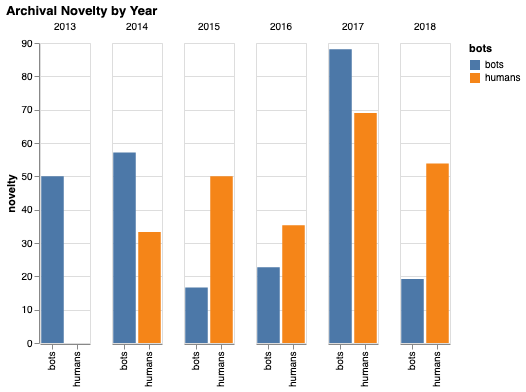

In [114]:
import altair
altair.renderers.enable('notebook')

novelty_df = pandas.DataFrame(novelty_by_year)

chart = altair.Chart(novelty_df).mark_bar().encode(
    altair.X('bots:N', title=''),    
    altair.Y('novelty:Q', axis=altair.Axis(format='%')),
    altair.Color('bots:N'), #, title='Bots', scale=altair.Scale(scheme='tableau20'))
    altair.Column('year:O', title=''),
)

chart = chart.properties(
    width=50,
    title='Archival Novelty by Year'
)

chart